In [1]:
import requests
import requests_cache
import requests_ftp
import lxml
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
from urlparse import urlunparse, urlparse
import pandas as pd
plt.style.use('ggplot')
requests_cache.install_cache('cache') # by using cache, the content you request will be stored locally.
%matplotlib inline       

In [4]:
def url_lxml(url,page):
    """
    input: url and page
    output: parse html to lxml 
    """
    response = requests.get(url+'/page/{}'.format(page))
    html = response.text  # xxx.text  ->  extract the text
    # this part if I run aggie = BeautifulSoup(aggiehtml,"lxml-xml"); aggie.prettify() is very short. Why???
    return BeautifulSoup(html,"lxml")

In [3]:
def link_art(url,page):
    """
    input: url and page
    output: links for the articles in each article lists
    """
    #response = requests.get(url)
    #html = response.text
    #aggie = BeautifulSoup(html,"lxml")
    #agglist_content = aggie.find_all(name="a",attrs={"itemprop":"name"})
    #aggie article list url: get the url for each article list
    #list_url = [x["href"]for x in agglist_content]
    all_links = []
    #for lists in list_url:
    article = url_lxml(url,page)
    art_content = article.find_all(name="h2",attrs={"class":"entry-title"})
        # there are some in <a> that don't have href attrs
    for art in art_content:
        try:                # use xxx.a gose down to a tag <a> directly 
            all_links.append(art.a["href"])
        except TypeError:
            None       
    return all_links

In [5]:
link_art("https://theaggie.org/campus",6)

['https://theaggie.org/2016/11/29/advocacy-groups-write-letters-to-uc-president-amid-concerns-of-anti-semitism/',
 'https://theaggie.org/2016/11/29/student-health-and-counseling-services-launches-nap-campaign/',
 'https://theaggie.org/2016/11/28/uc-davis-receives-760-million-for-research/',
 'https://theaggie.org/2016/11/27/two-sexual-assault-occurrences-reported-during-fall-quarter/',
 'https://theaggie.org/2016/11/27/this-week-in-senate-32/',
 'https://theaggie.org/2016/11/22/the-life-of-former-chancellor-linda-p-b-katehi-post-resignation/',
 'https://theaggie.org/2016/11/21/uc-davis-releases-2015-2016-annual-campus-travel-survey-results/',
 'https://theaggie.org/2016/11/21/plant-and-animal-sciences-at-uc-davis-rank-number-one-in-the-world/',
 'https://theaggie.org/2016/11/20/achieve-uc-program-encourages-students-to-apply-to-ucs/',
 'https://theaggie.org/2016/11/20/uc-transfer-application-deadline-extended/',
 'https://theaggie.org/2016/11/18/anti-diversity-posters-discovered-on-cam

In [6]:
import unicodedata
import re
def extra_content(url):  # in the website Inspector there is  ::before   what's the meaning of this??
    """
    input: url
    output: dictionary with author, text, title and url
    """
    # parse to lxml
    alllxml = url_lxml(url,1)
    # create a dictionary
    adict = {"author":[],"text":[],"title":[],"url":[]}
    #alllxml = url_lxml(test_art[0],1)
    # title
    titlelxml = alllxml.find_all(name="h1",attrs={"class":"entry-title","itemprop":"headline"})
    try:
        title = titlelxml[0].text.strip().encode('ascii','ignore')
    except IndexError:
        title = None
    adict["title"]=title
    # texts
    textlxml = alllxml.find_all("p")
    texts1 = [x.text.strip().encode('ascii','ignore') for x in textlxml]
    # author is not always in the last row. Most of the time it is the 2nd last row
    # xx[-1]: the last one; xx[:-1]: balabala untill the 2nd last one
    # all the text content
    adict["text"]="".join(texts1[:-2])
    # extract the author
    # use regular expression  "\s" is space. {n} means repeat n times. {1,3} means repeat 1 or 2 or 3 times
    try:
        author = re.search(".*:\s*([a-zA-Z -]+)\s.*@",texts1[-2]).group(1)
    except AttributeError:
        try:
            author = re.search(".*:\s*([a-zA-Z -]+)\s.*@",texts1[-1]).group(1)
        except AttributeError:
            author = None
    adict["author"]= author
    adict["url"] = url
    return adict

In [7]:
extra_content('https://theaggie.org/2016/11/29/advocacy-groups-write-letters-to-uc-president-amid-concerns-of-anti-semitism/')

{'author': 'Ivan Valenzuela ',
 'text': 'The letters come after two controversial student-led coursesEarlier this month, the AMCHA Initiative and Alums for Campus Fairness (ACF), sent out two open letters to the University of California (UC) president Janet Napolitano expressing concerns of anti-Zionist sentiment among UC professors and student instructors.The letters, which were signed by 176 faculty members, 590 alumni and 47 religious, civil rights, education and research organizations, came two months after a student-run course at UC Berkeley was suspended, and subsequently reinstated, amid accusations of failing to follow the UC Regents Policy on Course Content.We write to express our grave concern at what we believe to be the improper behavior of anti-Zionist faculty and student instructors, who use the classroom as a pulpit for political advocacy and activism in violation of UC policies and conventional academic ethics designed to curb exactly such abuse, AMCHA said in the lette

In [8]:
def create_df(news_link):                  # page 1-4
    """
    input: url links
    output: datafrmae of articles contents in 4 links (page 1-4)
    """
    all_link = [link_art(news_link,page) for page in range(1,5)]
    news = []
    for links in all_link:
        news_art = [extra_content(link) for link in links]
        news.append(news_art)
    return pd.concat([pd.DataFrame(new) for new in news])    
camp_df = create_df('https://theaggie.org/campus')
city_df = create_df('https://theaggie.org/city')

In [11]:
news_df = pd.concat([camp_df,city_df])
# simply use "+" to adding elements in the same list without creating nested lists
category = ["campus"]*60 + ["city"]*60
news_df["category"] = category
# reset the index value
news_df = news_df.set_index([range(120)])

In [12]:
news_df

,author,text,title,url,category
0,Alyssa Vandenberg,"Six senators, new executive team electedCurren...",2017 Winter Quarter election results,https://theaggie.org/2017/02/24/2017-winter-qu...,campus
1,Aaron Liss and Raul Castellanos,"Wells Fargo faces fraud, predatory lending cha...","University of California, Davis City Council s...",https://theaggie.org/2017/02/23/university-of-...,campus
2,Kimia Akbari,"Faculty, students recount personal tales of im...",Academics unite in peaceful rally against immi...,https://theaggie.org/2017/02/23/academics-unit...,campus
3,Kenton Goldsby,Opening date pushed back to May 1Students have...,Memorial Union to reopen Spring Quarter,https://theaggie.org/2017/02/23/memorial-union...,campus
4,Ivan Valenzuela,Veto included revision abandoning creation of ...,ASUCD President Alex Lee vetoes amendment for ...,https://theaggie.org/2017/02/23/asucd-presiden...,campus
5,Alyssa Vandenberg,"Shaheens name to remain on ballot, his votes w...",Senate candidate Zaki Shaheen withdraws from race,https://theaggie.org/2017/02/22/senate-candida...,campus
6,Aaron Liss,Students receive email warnings from UC Davis ...,UC Davis experiences several recent hate-based...,https://theaggie.org/2017/02/21/uc-davis-exper...,campus
7,Alyssa Vandenberg,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...,campus
8,Jeanna Totah,Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus
9,Ivan Valenzuela,SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus


In [14]:
import numpy as np
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [35]:
tokenize = nltk.word_tokenize
def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

In [36]:
textd = {} #dictionary from lemmata to document ids containing that lemma
textall=[]
for art in range(120):
    textall.append("".join(news_df.get_value(art,col="text"))) # get the text content
    d = news_df.get_value(art,col="title") 
    t = news_df.get_value(art,col="text")
    s = set(lemmatize(t))
    try: # by using toks | s, toks will combine elements of toks in the last iteration. Can I also use +?????
        toks = toks | s
    except NameError: # this is only used for the first iteration that no toks is created
        toks = s
    for tok in s:
        try: # lemmata : [title]
            textd[tok].append(d)
        except KeyError:
            textd[tok] = [d]
            
docids = {} #dictionary of the document id to an integer id for the document
N = 120  
for i in range(120):   # title : i
    docids[news_df.get_value(i,col="title")] = i
    
tokids = {} #dictionary of lemma to integer id for the lemma
tok_list = list(toks)  # a list of lemmata
m = len(tok_list) # the length of lemmata
for j in xrange(m):  # lemma : j
    tokids[tok_list[j]] = j    

In [37]:
# dictionary: lemma: number of documents this lemma occurs 
numd = {key:len(set(val)) for key,val in textd.items()}

logN = np.log(120)
# lemma : its smoothed idf
idf_smooth = {key:logN - np.log(1 + val) for key, val in numd.items() if val > 1}

In [21]:
idf_smooth

{'1,800': 3.6888794541139358,
 u'hatr': 3.401197381662155,
 'four': 2.3025850929940455,
 u'protest': 2.0149030205422647,
 'sleep': 3.6888794541139358,
 'asian': 3.401197381662155,
 'oldest': 3.6888794541139358,
 'hate': 2.2225423853205091,
 'whose': 3.1780538303479453,
 'saylor': 3.6888794541139358,
 'voter': 3.6888794541139358,
 u'bike': 2.8415815937267324,
 'under': 1.7429693050586228,
 '@': 3.401197381662155,
 u'everi': 1.6094379124341001,
 'risk': 2.7080502011022101,
 u'compassion': 3.6888794541139358,
 'blanket': 3.6888794541139358,
 u'rise': 3.1780538303479453,
 u'years.th': 3.6888794541139358,
 u'voic': 2.4849066497879999,
 u'tenni': 3.6888794541139358,
 'jack': 3.6888794541139358,
 u'unitran': 3.6888794541139358,
 u'govern': 2.0149030205422647,
 'jacob': 3.6888794541139358,
 'affect': 1.9542783987258296,
 u'school': 1.2611312181658842,
 u'scholar': 2.9957322735539909,
 u'later.th': 3.6888794541139358,
 u'showcas': 3.6888794541139358,
 u'environmentally-friendli': 3.688879454113

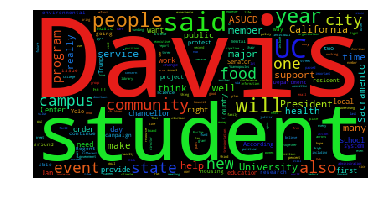

In [22]:
from os import path
from wordcloud import WordCloud
# all
wordcloud = WordCloud().generate("".join(textall))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

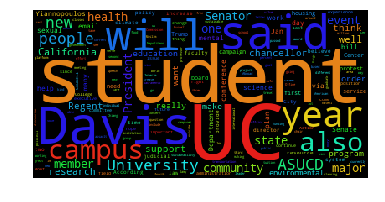

In [23]:
# for the campus news
wordcloud = WordCloud().generate("".join(textall[:59]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

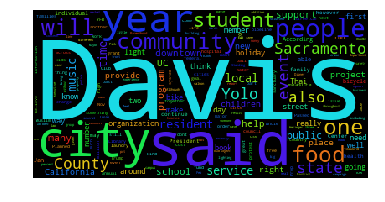

In [24]:
# for the city
wordcloud = WordCloud().generate("".join(textall[59:119]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [25]:
# the previous parts are only for calculating inverse document frequency
# now we want to know the idf with tf(t,d) weighted
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
# textall is a list of all raw texts
tfs = vectorizer.fit_transform(textall)
sim = tfs.dot(tfs.T)

In [26]:
# Find the smallest value
# in-place: update the original string instead of creating a new one
# convert the sparse matrix to a np.array by using .toarray() . And then I can use np.where(sim == sim.max()) to find the index of the max value
simay = sim.toarray()
#np.where(simay == simay.max())
simay.shape

(120L, 120L)

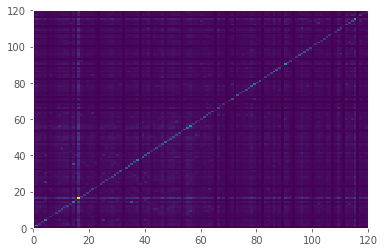

In [27]:
import numpy as np
#plt.imshow(simay, cmap='hot', interpolation='nearest')
plt.pcolor(simay)
plt.show()
# extract the upper diagonal
#simay_upp = np.triu(simay,k=0)

In [28]:
simay_upp = np.triu(simay,k=1) # k=1 make all the diagonal elements equal to 0
# order it to find the largest ones
def sim_art(n):   # get the index of sorted data
    flat = simay_upp.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    loc = np.unravel_index(indices, simay.shape)
    print [docids.keys()[docids.values().index(loc[0][n-1])], loc[0][n-1]]
    print [docids.keys()[docids.values().index(loc[1][n-1])], loc[1][n-1]]

In [29]:
# the most similar one
sim_art(1)

['UC Davis holds first mental health conference', 14]
['UC Davis to host first ever mental health conference', 35]


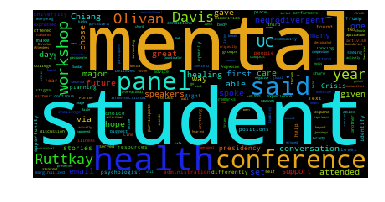

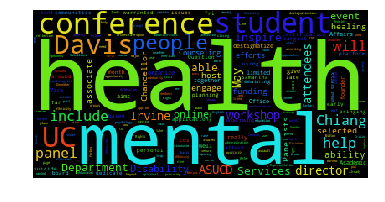

In [30]:
#show the similarity of this two articles
wordcloud = WordCloud().generate("".join(textall[14]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud = WordCloud().generate("".join(textall[35]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [31]:
# the 2nd similar one
sim_art(2)

['UC Davis holds first mental health conference', 14]
['2017 ASUCD Winter Elections  Meet the Candidates', 16]


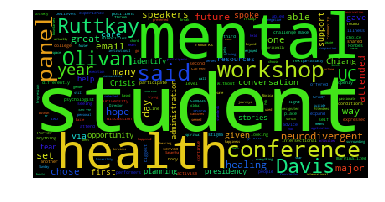

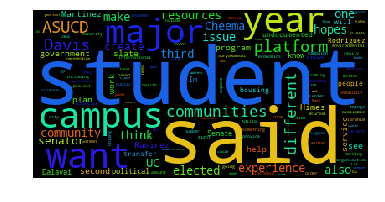

In [32]:
#show the similarity of this two articles
wordcloud = WordCloud().generate("".join(textall[14]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud = WordCloud().generate("".join(textall[16]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [33]:
# the 3rd similar one
sim_art(3)

['2017 ASUCD Winter Elections  Meet the Candidates', 16]
['Nov. 8 2016: An Election Day many may never forget', 115]


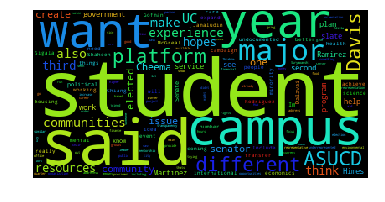

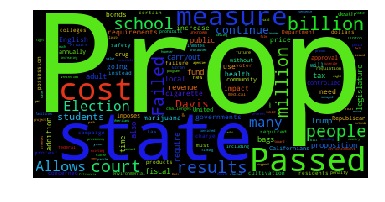

In [34]:
wordcloud = WordCloud().generate("".join(textall[16]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud = WordCloud().generate("".join(textall[115]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()